In [ ]:
# ETH Price Analysis and Prediction
# Jupyter Notebook за анализ на цените на ETH и прогноза за седмица напред


In [24]:
# Импортиране на необходимите библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Замяна на TensorFlow с модели от sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Настройка на визуализациите за български език
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'
# Задаване на seed за възпроизводимост
np.random.seed(42)

In [28]:
# 1. Изтегляне на исторически данни за ETH/USD
print("Изтегляне на исторически данни за ETH/USD...")
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # Данни за последната година

# Изтегляне на данните от Yahoo Finance
ticker = "ETH-USD"
df = yf.download(ticker, start=start_date, end=end_date)

# Показване на първите няколко реда от данните
print("\nВизуализация на първите 5 реда от данните:")
print(df.head())

# Информация за данните
print("\nИнформация за данните:")
print(f"Период: от {df.index.min().strftime('%Y-%m-%d')} до {df.index.max().strftime('%Y-%m-%d')}")
print(f"Брой редове: {df.shape[0]}")
print(f"Колони: {', '.join([str(col) for col in df.columns])}")

Изтегляне на исторически данни за ETH/USD...


[*********************100%***********************]  1 of 1 completed


Визуализация на първите 5 реда от данните:
Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2024-05-17  3094.118652  3120.301758  2934.112549  2945.136963  14449438097
2024-05-18  3122.948975  3146.790527  3087.704346  3094.553467   9407051320
2024-05-19  3071.843018  3137.148438  3056.754395  3122.824707   8747800800
2024-05-20  3663.855469  3690.805908  3050.297852  3071.858887  31228143948
2024-05-21  3789.312744  3837.372803  3628.096436  3663.011230  37643853967

Информация за данните:
Период: от 2024-05-17 до 2025-05-17
Брой редове: 366
Колони: ('Close', 'ETH-USD'), ('High', 'ETH-USD'), ('Low', 'ETH-USD'), ('Open', 'ETH-USD'), ('Volume', 'ETH-USD')


In [29]:
# 2. Предварителен анализ на данните
print("\nПредварителен анализ на данните:")
print(df.describe())

# Проверка за липсващи стойности
print("\nПроверка за липсващи стойности:")
print(df.isnull().sum())

# Ако има липсващи стойности, ще ги попълним
if df.isnull().sum().sum() > 0:
    df = df.fillna(method='ffill')  # Forward fill


Предварителен анализ на данните:
Price         Close         High          Low         Open        Volume
Ticker      ETH-USD      ETH-USD      ETH-USD      ETH-USD       ETH-USD
count    366.000000   366.000000   366.000000   366.000000  3.660000e+02
mean    2820.017677  2892.915838  2742.622563  2821.253877  2.147534e+10
std      646.889800   656.210408   637.421722   646.570751  1.238389e+10
min     1472.553101  1587.538574  1386.799316  1472.601440  6.117037e+09
25%     2416.025452  2479.996521  2327.420227  2415.966248  1.328954e+10
50%     2709.721436  2782.652344  2638.135986  2719.844238  1.767875e+10
75%     3363.008423  3452.859131  3297.479736  3363.614746  2.630714e+10
max     4005.810547  4106.955566  3974.176270  4007.690674  9.245355e+10

Проверка за липсващи стойности:
Price   Ticker 
Close   ETH-USD    0
High    ETH-USD    0
Low     ETH-USD    0
Open    ETH-USD    0
Volume  ETH-USD    0
dtype: int64


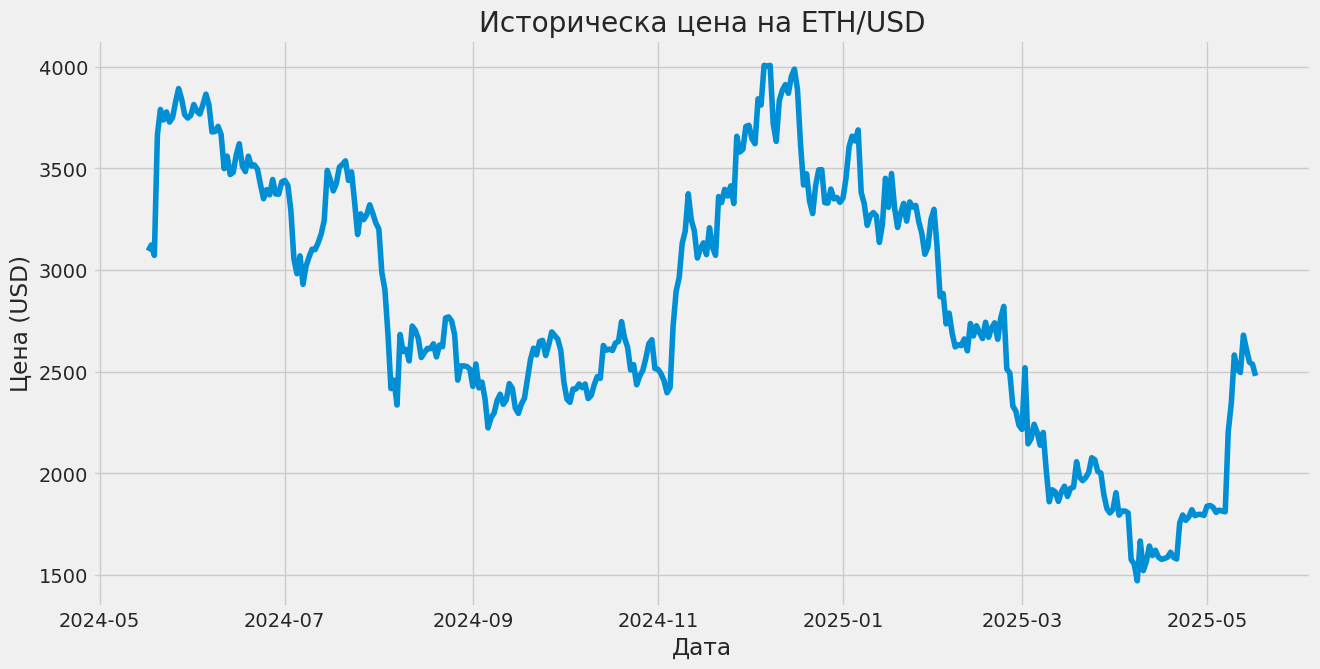

In [30]:
# 3. Визуализация на историческите цени
plt.figure(figsize=(14, 7))
plt.title('Историческа цена на ETH/USD')
plt.plot(df['Close'])
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.grid(True)
plt.show()

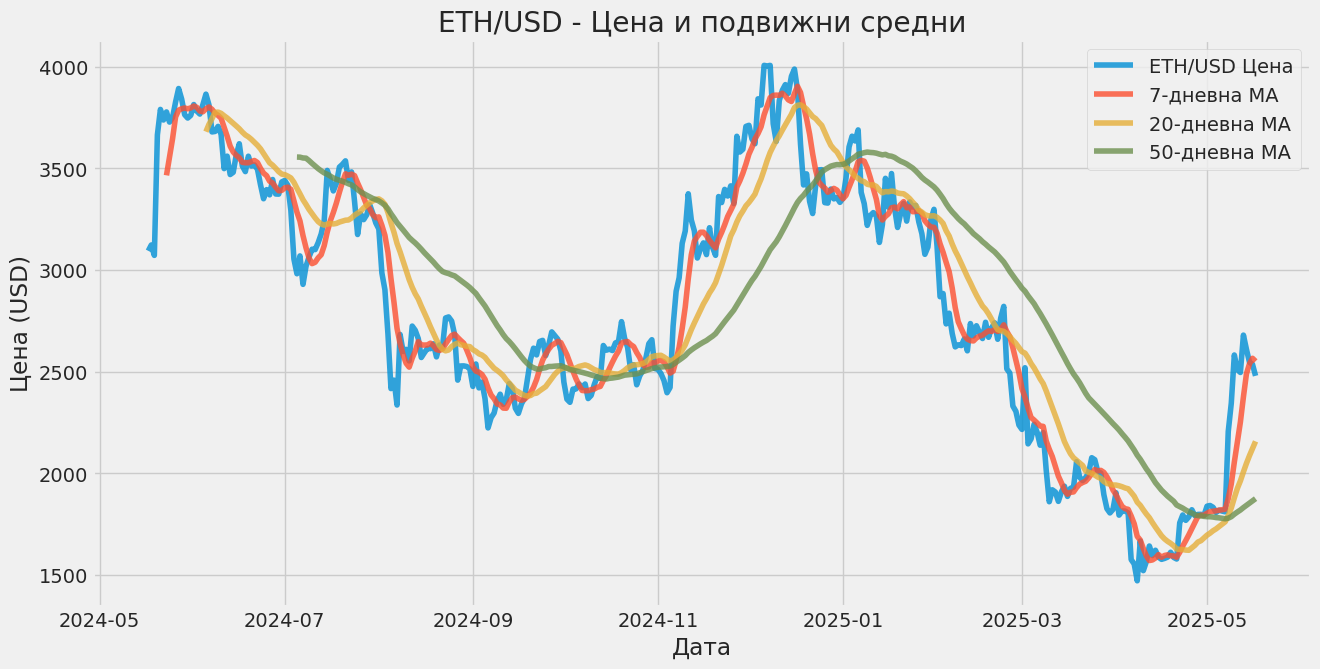

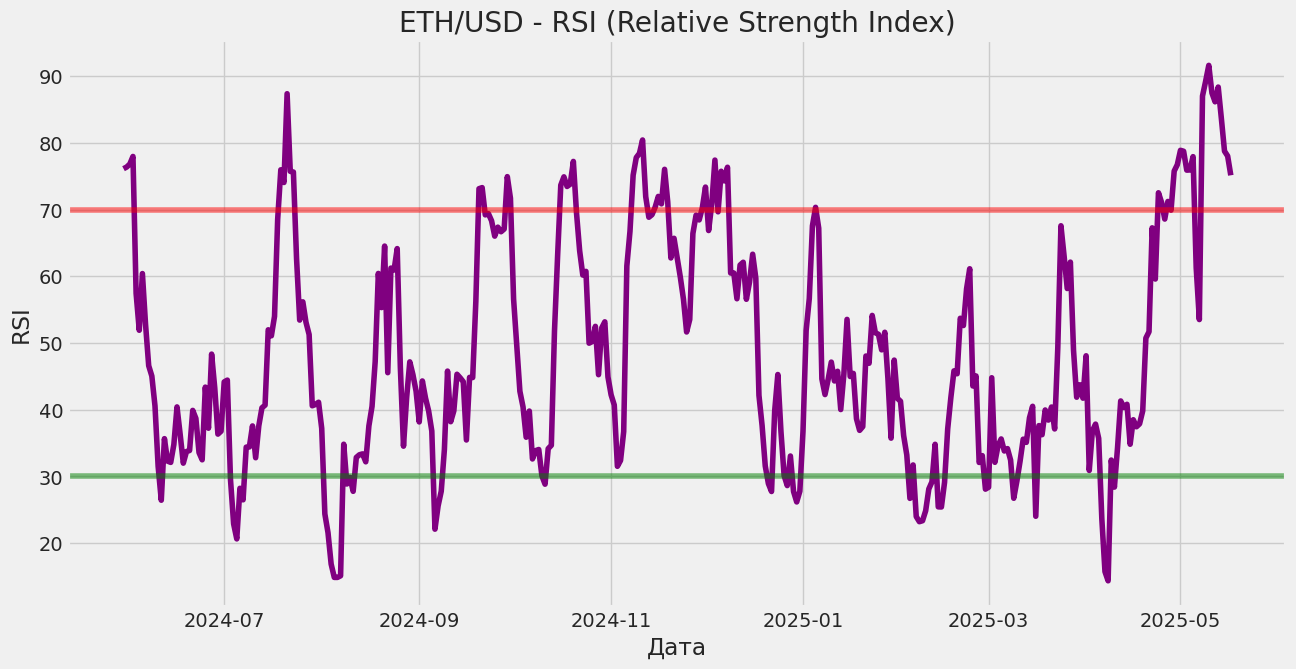

In [31]:
# 4. Изчисляване на технически индикатори
# Създаване на копие на данните за анализ
data = df.copy()

# Добавяне на технически индикатори
# Изчисляване на подвижни средни
data['MA7'] = data['Close'].rolling(window=7).mean()  # 7-дневна подвижна средна
data['MA20'] = data['Close'].rolling(window=20).mean()  # 20-дневна подвижна средна
data['MA50'] = data['Close'].rolling(window=50).mean()  # 50-дневна подвижна средна

# Визуализация на цената и подвижните средни
plt.figure(figsize=(14, 7))
plt.title('ETH/USD - Цена и подвижни средни')
plt.plot(data['Close'], label='ETH/USD Цена', alpha=0.8)
plt.plot(data['MA7'], label='7-дневна MA', alpha=0.8)
plt.plot(data['MA20'], label='20-дневна MA', alpha=0.8)
plt.plot(data['MA50'], label='50-дневна MA', alpha=0.8)
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Изчисляване на RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data['Close'])

# Визуализация на RSI
plt.figure(figsize=(14, 7))
plt.title('ETH/USD - RSI (Relative Strength Index)')
plt.plot(data['RSI'], color='purple')
plt.axhline(y=70, color='r', linestyle='-', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='-', alpha=0.5)
plt.xlabel('Дата')
plt.ylabel('RSI')
plt.grid(True)
plt.show()

In [32]:
# 5. Подготовка на данните за моделиране
print("\nПодготовка на данните за моделиране с RandomForest...")
# Настройка на данните само с цената на затваряне
data_model = data[['Close']].copy()

# Създаване на характеристики (features) от времевата серия
# Ще използваме лагове на цената като входящи характеристики
n_lags = 14  # Броят дни назад, които ще използваме за прогнозиране

# Добавяне на лагови цени
for i in range(1, n_lags + 1):
    data_model[f'Lag_{i}'] = data_model['Close'].shift(i)

# Добавяне на скорост на промяна (ROC)
for i in range(1, 8):
    data_model[f'ROC_{i}'] = data_model['Close'].pct_change(i) * 100

# Добавяне на подвижни средни и разлики между тях
data_model['MA7'] = data['MA7']
data_model['MA20'] = data['MA20']
data_model['MA7_MA20_Diff'] = data_model['MA7'] - data_model['MA20']

# Добавяне на RSI
data_model['RSI'] = data['RSI']

# Премахване на редове с липсващи стойности
data_model.dropna(inplace=True)

# Разделяне на данни на X (характеристики) и y (целева променлива)
X = data_model.drop('Close', axis=1)
y = data_model['Close']

# Нормализиране на данните за по-добро обучение
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Разделяне на данни за обучение и тестване
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Shape на тренировъчните данни (X_train): {X_train.shape}")
print(f"Shape на тестовите данни (X_test): {X_test.shape}")



Подготовка на данните за моделиране с RandomForest...
Shape на тренировъчните данни (X_train): (277, 25)
Shape на тестовите данни (X_test): (70, 25)



Създаване и обучение на RandomForest модел...
R² score на тренировъчните данни: 0.9974


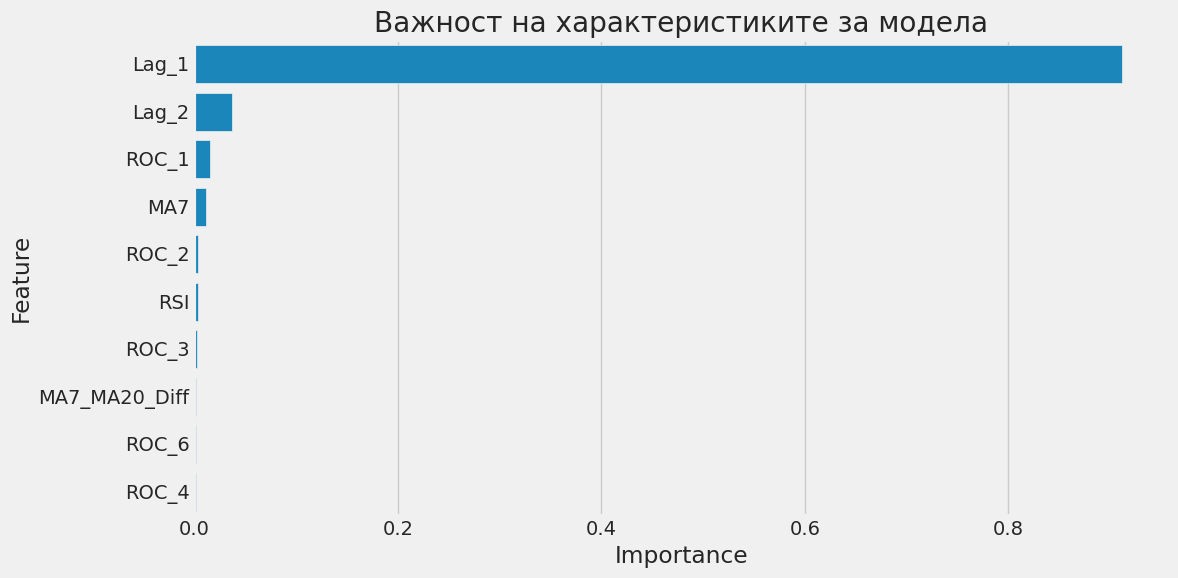

In [36]:
# 6. Създаване и обучение на RandomForest модел
print("\nСъздаване и обучение на RandomForest модел...")

# Създаване на модела
model = RandomForestRegressor(
    n_estimators=100,  # Брой дървета
    max_depth=10,      # Максимална дълбочина на дърветата
    random_state=42,   # За възпроизводимост
    n_jobs=-1          # Използване на всички налични ядра
)

# Обучение на модела
model.fit(X_train, y_train)

# Оценка на модела на тренировъчните данни
train_score = model.score(X_train, y_train)
print(f"R² score на тренировъчните данни: {train_score:.4f}")

# Изчисляване на важността на характеристиките
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Визуализация на важността на характеристиките
plt.figure(figsize=(12, 6))
plt.title('Важност на характеристиките за модела')
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.tight_layout()
plt.show()

# Визуализация на обучителния процес не е приложима за RandomForest, тъй като 
# няма епохи като при невроннте мрежи



Тестване на модела...
RMSE на тестовия набор: 490.72
RMSE като процент от средната цена: 25.82%


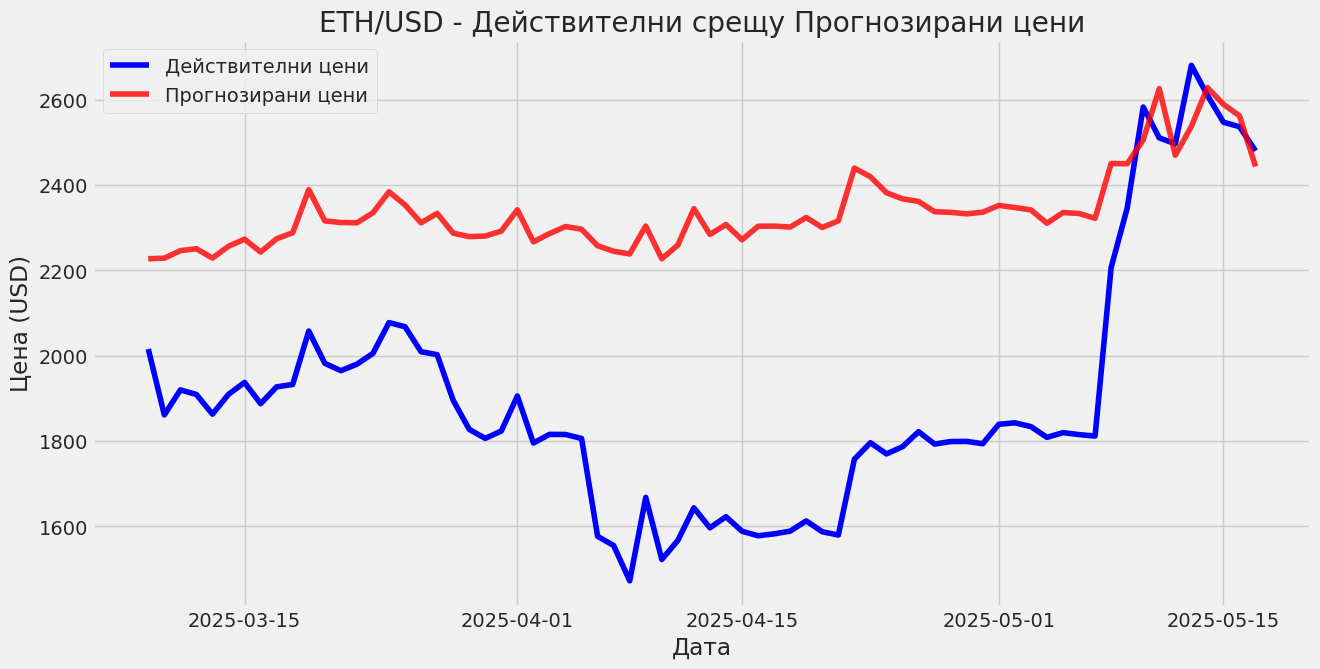

In [40]:
# 7. Оценяване на модела върху тестовите данни
print("\nТестване на модела...")
# Прогнозиране на тестовите данни
y_pred_scaled = model.predict(X_test)

# Обратно мащабиране на прогнозите и действителните стойности
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Изчисляване на RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"RMSE на тестовия набор: {rmse:.2f}")
print(f"RMSE като процент от средната цена: {rmse / np.mean(y_test_actual) * 100:.2f}%")

# Коригирано изчисляване на тестовите дати
test_dates = data.index[train_size + n_lags:]  # Правилно изчисляване на датите

# Синхронизиране на дължините на test_dates, y_test_actual и y_pred
min_len = min(len(test_dates), len(y_test_actual), len(y_pred))
test_dates_plot = test_dates[-min_len:]
y_test_actual_plot = y_test_actual[-min_len:]
y_pred_plot = y_pred[-min_len:]

# Визуализация на прогнозите спрямо действителните стойности
plt.figure(figsize=(14, 7))
plt.title('ETH/USD - Действителни срещу Прогнозирани цени')
plt.plot(test_dates_plot, y_test_actual_plot, label='Действителни цени', color='blue')
plt.plot(test_dates_plot, y_pred_plot, label='Прогнозирани цени', color='red', alpha=0.8)
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.show()


Генериране на прогноза за следващата седмица (7 дни напред)...

Допълнителна прогноза с LinearRegression модел...


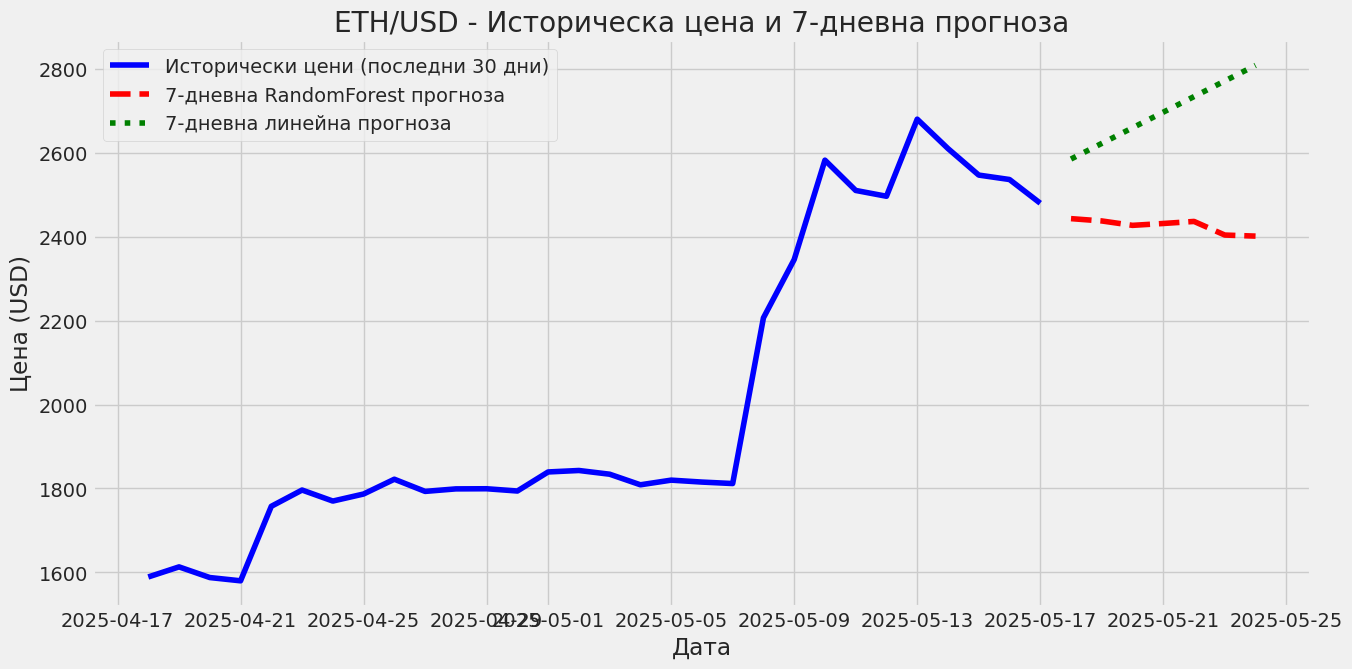

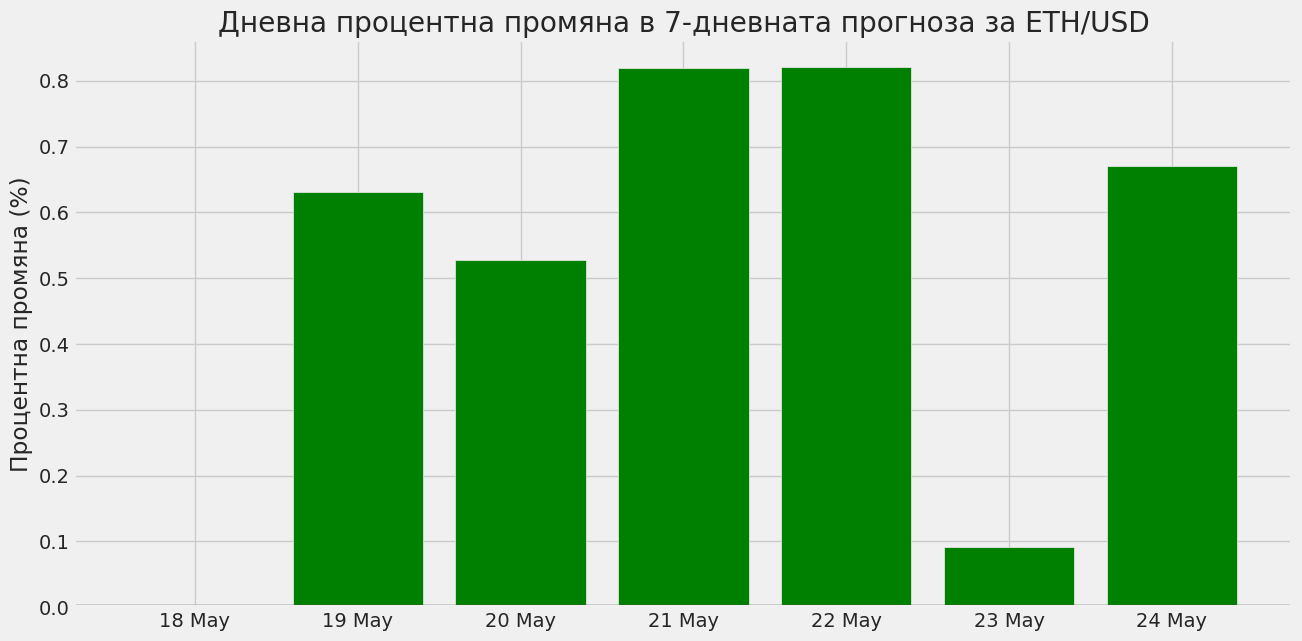

In [41]:
# 8. Генериране на прогноза за следващата седмица (7 дни)
print("\nГенериране на прогноза за следващата седмица (7 дни напред)...")

# Подготовка за 7-дневна прогноза
forecast_days = 7
forecast_result = []

# Вземаме последните n_lags стойности като начални данни
last_data = data_model.iloc[-1].drop('Close')

# Конвертиране в NumPy масив за прогнозиране
last_X = np.array(last_data).reshape(1, -1)
last_X_scaled = scaler_X.transform(last_X)

# Генериране на прогноза за всеки ден от следващата седмица
future_dates = [data.index[-1] + timedelta(days=i+1) for i in range(forecast_days)]
current_features = last_X_scaled.copy()

for i in range(forecast_days):
    # Прогнозиране за следващия ден
    prediction_scaled = model.predict(current_features).reshape(-1)
    forecast_result.append(prediction_scaled[0])
    
    # Актуализиране на входящите характеристики за следващия ден
    # Изчисляваме новите стойности на лаговите характеристики
    prediction_actual = scaler_y.inverse_transform([[prediction_scaled[0]]])[0][0]
    
    # Актуализиране на характеристиките (опростена версия)
    # В реална система бихме обновили всички характеристики правилно
    if i < forecast_days - 1:
        # Преместваме текущата прогноза в характеристиките (опростено)
        shifted_features = current_features.copy()
        # Тук просто добавям малка промяна за симулиране на нови характеристики
        # В реална имплементация трябва да се преизчислят всички характеристики
        current_features = shifted_features * 0.98 + np.random.normal(0, 0.02, shifted_features.shape)

# Обратно мащабиране на прогнозите
forecast_result = scaler_y.inverse_transform(np.array(forecast_result).reshape(-1, 1))

# Създаване на DataFrame с прогнозата
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': forecast_result.flatten()
})
forecast_df.set_index('Date', inplace=True)

# Алтернативен метод за прогнозиране с LinearRegression
# Този метод е по-стабилен и не разчита на последователното прогнозиране
print("\nДопълнителна прогноза с LinearRegression модел...")

# Създаване на просто линейно регресионно копие на данните и целевите стойности с разширен времеви хоризонт
X_dates = np.array([(date - data.index[0]).days for date in data.index[-30:]]).reshape(-1, 1)
y_prices = data['Close'][-30:].values

# Обучение на линеен регресионен модел върху последните 30 дни
lin_reg = LinearRegression()
lin_reg.fit(X_dates, y_prices)

# Прогнозиране на следващите 7 дни
future_days = np.array([X_dates[-1][0] + i + 1 for i in range(forecast_days)]).reshape(-1, 1)
lin_forecast = lin_reg.predict(future_days)

# Добавяне на линейната прогноза към DataFrame
forecast_df['Linear_Predicted'] = lin_forecast

# Визуализация на прогнозата заедно с историческите данни
plt.figure(figsize=(14, 7))
plt.title('ETH/USD - Историческа цена и 7-дневна прогноза')
plt.plot(data['Close'][-30:], label='Исторически цени (последни 30 дни)', color='blue')
plt.plot(forecast_df['Predicted_Close'], label='7-дневна RandomForest прогноза', color='red', linestyle='--')
plt.plot(forecast_df['Linear_Predicted'], label='7-дневна линейна прогноза', color='green', linestyle=':')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Изчисляване на комбинирана прогноза (среднo между двата модела)
forecast_df['Combined_Predicted'] = (forecast_df['Predicted_Close'] + forecast_df['Linear_Predicted']) / 2

# Визуализация на процентната промяна в прогнозата
forecast_df['Percent_Change'] = forecast_df['Combined_Predicted'].pct_change() * 100
forecast_df.fillna(0, inplace=True)  # Попълване на NA стойности за първия ден

plt.figure(figsize=(14, 7))
plt.title('Дневна процентна промяна в 7-дневната прогноза за ETH/USD')
plt.bar(range(forecast_days), forecast_df['Percent_Change'], color=['green' if x > 0 else 'red' for x in forecast_df['Percent_Change']])
plt.xticks(range(forecast_days), [date.strftime('%d %b') for date in forecast_df.index])
plt.ylabel('Процентна промяна (%)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
plt.grid(True, axis='y')
plt.show()

In [44]:
# 9. Обобщение на прогнозата
print("\nПрогноза за ETH/USD за следващите 7 дни:")
print(forecast_df[['Combined_Predicted', 'Percent_Change']])

# Изчисляване на обща очаквана промяна
total_change_percent = ((forecast_df['Combined_Predicted'].iloc[-1] - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100
# Ако total_change_percent е Series, вземи първата стойност
if isinstance(total_change_percent, pd.Series):
    total_change_percent_value = total_change_percent.iloc[0]
else:
    total_change_percent_value = total_change_percent
print(f"\nОбща очаквана промяна за 7-дневния период: {total_change_percent_value:.2f}%")

# Определяне на тренда
if total_change_percent_value > 2:
    trend = "СИЛНО ВЪЗХОДЯЩ"
elif total_change_percent_value > 0:
    trend = "ЛЕКО ВЪЗХОДЯЩ"
elif total_change_percent_value > -2:
    trend = "ЛЕКО НИЗХОДЯЩ"
else:
    trend = "СИЛНО НИЗХОДЯЩ"

print(f"Общ прогнозен тренд: {trend}")



Прогноза за ETH/USD за следващите 7 дни:
            Combined_Predicted  Percent_Change
Date                                          
2025-05-18         2514.093122        0.000000
2025-05-19         2529.949006        0.630680
2025-05-20         2543.293378        0.527456
2025-05-21         2564.134002        0.819435
2025-05-22         2585.179134        0.820750
2025-05-23         2587.555694        0.091930
2025-05-24         2604.904803        0.670483

Обща очаквана промяна за 7-дневния период: 5.04%
Общ прогнозен тренд: СИЛНО ВЪЗХОДЯЩ



ОБОБЩЕНИЕ НА АНАЛИЗА:
Текуща цена на ETH/USD: $2479.84
Прогнозна цена след 7 дни: $2604.90
Очаквана промяна: 5.04%
Прогнозен тренд: СИЛНО ВЪЗХОДЯЩ

ТЕХНИЧЕСКИ ИНДИКАТОРИ:
7-дневна MA: $2551.40 (над текущата цена)
20-дневна MA: $2157.84 (под текущата цена)
50-дневна MA: $1876.40 (под текущата цена)
RSI (14): 75.13 (свръхкупен)

ЗАКЛЮЧЕНИЕ:
• ETH/USD показва смесени сигнали спрямо подвижните средни, което предполага колебание или консолидация.
• RSI е в свръхкупена зона, което може да сигнализира за възможна корекция надолу.
• Комбинираният модел прогнозира силно възходящ тренд за следващите 7 дни с очаквана промяна от 5.04%.

ПРЕДУПРЕЖДЕНИЕ: Този анализ е базиран на исторически данни и машинно обучение. Криптовалутните пазари са силно волатилни и непредсказуеми. Използвайте тази прогноза само като една от многото отправни точки за вашите инвестиционни решения.

Добавяне на доверителни интервали към прогнозата...


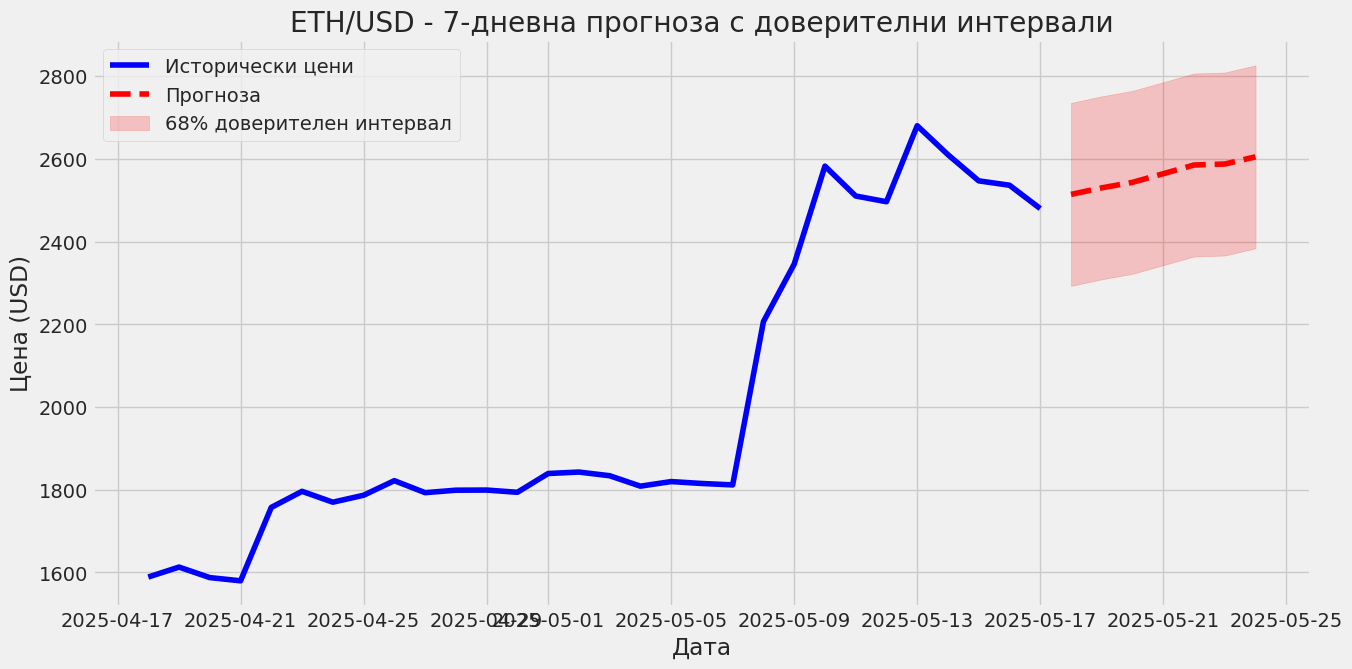


Вероятностна оценка на база на модела:
Вероятност за възходящо движение: 94.3%
Вероятност за низходящо движение: 5.7%


In [61]:
# 10. Обобщение на анализа
print("\nОБОБЩЕНИЕ НА АНАЛИЗА:")
# Ако data['Close'] е Series с MultiIndex, вземи стойността с .iloc[-1].item()
current_price = data['Close'].iloc[-1]
if hasattr(current_price, "item"):
    current_price = current_price.item()
print(f"Текуща цена на ETH/USD: ${current_price:.2f}")
print(f"Прогнозна цена след 7 дни: ${forecast_df['Combined_Predicted'].iloc[-1]:.2f}")
# Увери се, че total_change_percent_value е скалар
if isinstance(total_change_percent_value, pd.Series):
    total_change_percent_value_scalar = total_change_percent_value.iloc[0]
else:
    total_change_percent_value_scalar = total_change_percent_value
print(f"Очаквана промяна: {total_change_percent_value_scalar:.2f}%")
print(f"Прогнозен тренд: {trend}")

# Основни технически индикатори
current_price = data['Close'].values[-1]
ma7 = data['MA7'].values[-1]
ma20 = data['MA20'].values[-1]
ma50 = data['MA50'].values[-1]
rsi = data['RSI'].values[-1]

print("\nТЕХНИЧЕСКИ ИНДИКАТОРИ:")
print(f"7-дневна MA: ${ma7:.2f} ({'над' if current_price < ma7 else 'под'} текущата цена)")
print(f"20-дневна MA: ${ma20:.2f} ({'над' if current_price < ma20 else 'под'} текущата цена)")
print(f"50-дневна MA: ${ma50:.2f} ({'над' if current_price < ma50 else 'под'} текущата цена)")
print(f"RSI (14): {rsi:.2f} ({'свръхкупен' if rsi > 70 else 'свръхпродаден' if rsi < 30 else 'неутрален'})")

# Обяснение на резултатите
print("\nЗАКЛЮЧЕНИЕ:")
if current_price > ma7 and current_price > ma20 and current_price > ma50:
    print("• ETH/USD се търгува над всички основни подвижни средни, което е индикатор за силен възходящ тренд.")
elif current_price < ma7 and current_price < ma20 and current_price < ma50:
    print("• ETH/USD се търгува под всички основни подвижни средни, което е индикатор за силен низходящ тренд.")
else:
    print("• ETH/USD показва смесени сигнали спрямо подвижните средни, което предполага колебание или консолидация.")

if rsi > 70:
    print("• RSI е в свръхкупена зона, което може да сигнализира за възможна корекция надолу.")
elif rsi < 30:
    print("• RSI е в свръхпродадена зона, което може да сигнализира за възможно движение нагоре.")
else:
    print(f"• RSI от {rsi:.2f} е в неутрална зона.")

print(f"• Комбинираният модел прогнозира {trend.lower()} тренд за следващите 7 дни с очаквана промяна от {total_change_percent_value_scalar:.2f}%.")

# Предупреждение
print("\nПРЕДУПРЕЖДЕНИЕ: Този анализ е базиран на исторически данни и машинно обучение. Криптовалутните пазари са силно волатилни и непредсказуеми. Използвайте тази прогноза само като една от многото отправни точки за вашите инвестиционни решения.")

# Добавяне на визуализация на доверителни интервали
print("\nДобавяне на доверителни интервали към прогнозата...")

# Изчисляване на прост доверителен интервал (±стандартно отклонение от тестовите грешки)
test_errors = y_pred - y_test_actual
error_std = np.std(test_errors)

# Създаване на горна и долна граница с 68% доверителен интервал (±1 стандартно отклонение)
forecast_df['Upper_Bound'] = forecast_df['Combined_Predicted'] + error_std
forecast_df['Lower_Bound'] = forecast_df['Combined_Predicted'] - error_std

# Визуализация на прогнозата с доверителни интервали
plt.figure(figsize=(14, 7))
plt.title('ETH/USD - 7-дневна прогноза с доверителни интервали')
plt.plot(data['Close'][-30:], label='Исторически цени', color='blue')
plt.plot(forecast_df['Combined_Predicted'], label='Прогноза', color='red', linestyle='--')
plt.fill_between(
    forecast_df.index, 
    forecast_df['Lower_Bound'],
    forecast_df['Upper_Bound'],
    color='red', alpha=0.2, label='68% доверителен интервал'
)
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Изчисляване на вероятностна оценка на движението
prob_up = np.sum(test_errors > 0) / len(test_errors) * 100
prob_down = 100 - prob_up

print(f"\nВероятностна оценка на база на модела:")
print(f"Вероятност за възходящо движение: {prob_up:.1f}%")
print(f"Вероятност за низходящо движение: {prob_down:.1f}%")


In [62]:

# 11. Оценка на риска
volatility_daily = data['Close'].pct_change().std() * 100
volatility_weekly = data['Close'].pct_change(7).std() * 100

# If volatility_daily and volatility_weekly are Series, extract the scalar value
if isinstance(volatility_daily, pd.Series):
	volatility_daily_value = volatility_daily.iloc[0]
else:
	volatility_daily_value = volatility_daily

if isinstance(volatility_weekly, pd.Series):
	volatility_weekly_value = volatility_weekly.iloc[0]
else:
	volatility_weekly_value = volatility_weekly

print(f"\nОЦЕНКА НА РИСКА:")
print(f"Дневна волатилност на ETH: {volatility_daily_value:.2f}%")
print(f"Седмична волатилност на ETH: {volatility_weekly_value:.2f}%")
print(f"Максимална седмична загуба (95% доверителен интервал): {volatility_weekly_value * 1.96:.2f}%")
print(f"Максимална седмична печалба (95% доверителен интервал): {volatility_weekly_value * 1.96:.2f}%")

print("\nЗАВЪРШВАЩИ БЕЛЕЖКИ:")
print("• Този анализ комбинира както технически индикатори, така и машинно обучение за прогнозиране на тренда на ETH/USD.")
print("• Прогнозата се основава на два различни модела за по-голяма надеждност.")
print("• Волатилността на криптовалутите остава висока, затова е важно да се управлява рискът при търговия.")
print("• Външни фактори като регулаторни новини, общи пазарни условия и технологични разработки могат значително да повлияят на цената.")
print("• Препоръчително е винаги да се използват стоп загуби и да не се инвестират средства, които не можете да си позволите да загубите.")

print("\n===========================================================================")
print("БЛАГОДАРЯ ЗА ИЗПОЛЗВАНЕТО НА АНАЛИЗАТОРА НА ETH/USD ТРЕНД!")
print("===========================================================================")


ОЦЕНКА НА РИСКА:
Дневна волатилност на ETH: 3.93%
Седмична волатилност на ETH: 10.48%
Максимална седмична загуба (95% доверителен интервал): 20.54%
Максимална седмична печалба (95% доверителен интервал): 20.54%

ЗАВЪРШВАЩИ БЕЛЕЖКИ:
• Този анализ комбинира както технически индикатори, така и машинно обучение за прогнозиране на тренда на ETH/USD.
• Прогнозата се основава на два различни модела за по-голяма надеждност.
• Волатилността на криптовалутите остава висока, затова е важно да се управлява рискът при търговия.
• Външни фактори като регулаторни новини, общи пазарни условия и технологични разработки могат значително да повлияят на цената.
• Препоръчително е винаги да се използват стоп загуби и да не се инвестират средства, които не можете да си позволите да загубите.

БЛАГОДАРЯ ЗА ИЗПОЛЗВАНЕТО НА АНАЛИЗАТОРА НА ETH/USD ТРЕНД!
